In [16]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [17]:
import numpy as np
import pandas as pd

In [18]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [20]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [21]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [22]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [23]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [25]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [26]:
#see column names and types of measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [27]:
#see column names and types of station
columns = inspector.get_columns('station')
for c in columns: 
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [28]:
x = session.query(measurement)
x_df = pd.read_sql(x.statement, x.session.bind)
x_df

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [29]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
# year_past = dt.date(last_date) - dt.timedelta(days=365)
last_date

('2017-08-23')

In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

last_12_months = session.query(measurement.date, measurement.prcp).filter(measurement.date.between('2016-08-23', '2017-08-23'))
    
last_12_months_df = pd.read_sql(last_12_months.statement, last_12_months.session.bind).dropna()
last_12_months_sorted = last_12_months_df.sort_values('date')
last_12_months_sorted.set_index('date', inplace=True)



/Users/lainiecanfield/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


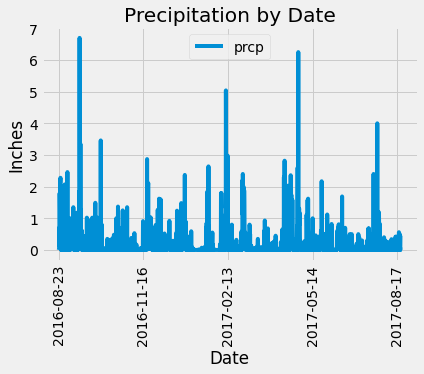

In [36]:
# Use Pandas Plotting with Matplotlib to plot the data
# Use Pandas Plotting with Matplotlib to plot the data


last_12_months_sorted.plot(title="Precipitation by Date")
plt.legend(loc='upper center')
plt.xticks(rotation=90)
plt.ylabel("Inches")
plt.xlabel("Date")
plt.show()





In [37]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12_months_sorted.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [38]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(measurement).group_by(measurement.station).count()
stations


9

In [39]:
# What are the most active stations? (i.e. what stations have the most rows)?

results = session.query(func.count(measurement.station), measurement.station).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
        
# # # List the stations and the counts in descending order.
results


[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [40]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [measurement.station,
      func.min(measurement.tobs),
      func.max(measurement.tobs),
      func.avg(measurement.tobs)]

active_station_query = session.query(*sel).\
    filter(measurement.station == 'USC00519281')

active_station_df = pd.read_sql(active_station_query.statement, active_station_query.session.bind)
active_station_df

,station,min_1,max_1,avg_1
0,USC00519281,54.0,85.0,71.663781


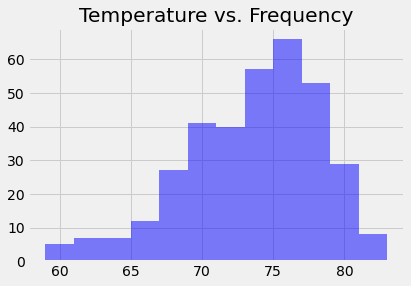

In [46]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
dates = session.query(func.min(measurement.date), func.max(measurement.date)).all()

high_station = session.query(measurement.date, measurement.tobs).\
    filter(measurement.date.between('2016-08-23', '2017-08-23')).\
    filter(measurement.station == "USC00519281")
           
high_station_df = pd.read_sql(high_station.statement, high_station.session.bind)
high_station_df

x = high_station_df['tobs']
num_bins = 12
plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.title("Temperature vs. Frequency")
plt.show()


## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'Measurement' is not defined

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
